# Kannada MNIST

In modeling this data, I'll be following a three step training process, to create the best possible senario for creating my final predictions.  

**First Training** In the first training of the model I'll be using a traditional train/test split of the training data alone, to both training and validate the model. If I notice the model overfits notably, I'll implement different techniques to reduce/correct this issue. To prevent overfitting I will either be increasing the dropout rate in the various Dropout layers in the model, by increasing the amount of pooling layers, or by implementing som eform of regulation.  

**Second Training** In the second training of the model, I'll be using the entirity of the training data set to train the model, and then wil validate the model on the validation set, `Dig-MNIST.csv`. It may be easier to notice the effects of any overfitting in the model at this stage than it is in the original model, as I'll have the benefit of a much larger dataset, increasing the effect of overfitting if such an issue previously existed. If I notice such an issue, I'll again implement different techniques to reduce/correct this issue.  

**Third Training** In the third and final training stage of the model, I will concatenate the training and validation data sets to create a new training set, `train_total`. I'll then use this uber-set to train the final model which will be used to predict the labels of the test set.

In [1]:
#Imports
import numpy as np
import pandas as pd

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

#Modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

#Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, MaxPool2D, Conv2D, Flatten, Dropout, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


## Data
### Exploratory Analysis
The data for this challenge can be found on [the kaggle competition page](). It consists of three seperate files: the training set, `train.csv`, the validation set, `Dig-MNIST.csv`, and the testing set, `test.csv`. These three sets each contain image data, stored in row/column styles. As such, each row of the data sets reflects a specific image, while the rows describe the information for the image. The first row contains the image label (or an id in the case of the test set), a number between 0-9, and the last 784 columns each show the value of the individual pixels as an integer between 0 and 255, inclusive, for the 28 x 28 pixel images.

In [2]:
#Data import
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")
validation = pd.read_csv("Data/Dig-MNIST.csv")

To verify the construction of the three dataframes, we will quickly review the first few rowsof the data.

**Training Data**  
This data will be used through the training of all models.

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In grouping the training data by their labels we can verify the number of classes in our data, as well as the distribution of the digits in the data set. Ideally the sampling distribution of the digits should be uniform.

Text(0.5, 1.0, 'Distribution of Digit Samples in the Training Set')

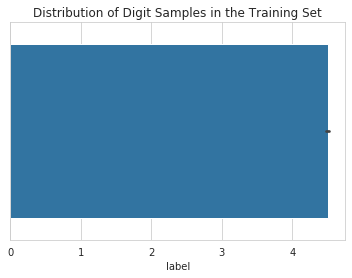

In [4]:
sns.barplot(train["label"])
plt.title("Distribution of Digit Samples in the Training Set")

In [5]:
train.groupby(train["label"]).size()

label
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
dtype: int64

**Validation Data**  
This data will be used as the validation data in the model witch trains on the full training set, and will be concatenated with the training data for the final submission model.

In [6]:
validation.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Although we don't usually need to be as highly concerned with the distribution of the test set, I will be, at some point in the analysis, combining the training and validation data, to fully train the model I'll be using for my submission, in order to provide the most training data as possible for the final model.  
As such, I'm going to review the distribution of the validation set as well.

Text(0.5, 1.0, 'Distribution of Digit Samples in Validation Set')

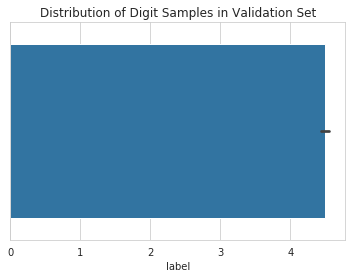

In [7]:
sns.barplot(validation["label"])
plt.title("Distribution of Digit Samples in Validation Set")

In [8]:
validation.groupby(validation["label"]).size()

<bound method GroupBy.size of <pandas.core.groupby.generic.DataFrameGroupBy object at 0x7fb387142dd8>>

**Testing Data**  
This data will be used to generate the class predictions for the competition submissions.

In [9]:
test.head()

,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data Treatment and Augmentation
#### Data Treatment
As the data is presented in row/column format, I need to transform it into matrix format both to visualize the images and for the keras CNN model I will be building.

First I'll be spliting the label and id columns off of the three data sets, and storing them in seperate variables. I'll then be creating array verisions of the pixel information for the images. The labels will be sent to binary matrices made up of the class vectors for the labels, while the pixel information will be reshapped into the 28 x 28 pixel images. The pixel information will also be normalized, such the maxium pixel value will be 1, with a minimum of zero, to improve the accuracy of the model.

In [10]:
#Spliting off labels/Ids
train_labels = to_categorical(train.iloc[:,0])
train = train.iloc[:, 1:].values

X_validation = validation.iloc[:, 1:].values
y_validation = to_categorical(validation.iloc[:,0])

test_id = test.iloc[:, 0]
test = test.iloc[:, 1:].values

In [11]:
#Normalizing the data
train = train/255
X_validation = X_validation/255

test = test/255

In [12]:
#Reshaping data
train = train.reshape(train.shape[0], 28, 28, 1)

X_validation = X_validation.reshape(validation.shape[0], 28, 28, 1)

test = test.reshape(test.shape[0], 28, 28, 1)

With our data now in the correct shape, lets visualize the training and the validation sets.

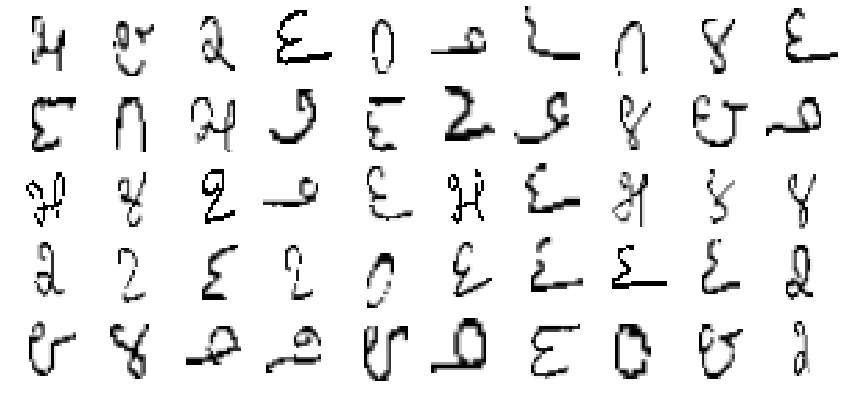

In [13]:
#Visualizing the Training Data
fig, ax = plt.subplots(5, 10)
for i in range(5):
    for j in range(10):
        ax[i][j].imshow(train[np.random.randint(0, train.shape[0]), :, :, 0], cmap = plt.cm.binary)
        ax[i][j].axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
fig.set_figwidth(15)
fig.set_figheight(7)
plt.savefig("Images/Random_digits_from_train.png")

The above is a random selection of 50 different diits in the training set. 

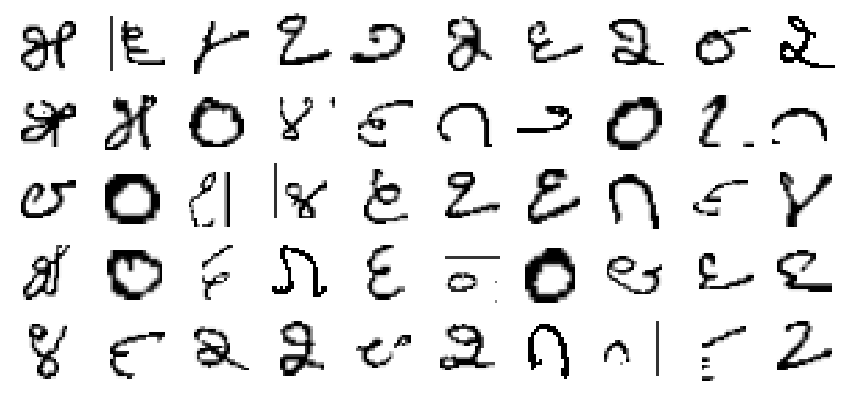

In [14]:
#Visualizing the Validation Data
fig, ax = plt.subplots(5, 10)
for i in range(5):
    for j in range(10):
        ax[i][j].imshow(X_validation[np.random.randint(0, X_validation.shape[0]), :, :, 0], cmap = plt.cm.binary)
        ax[i][j].axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
fig.set_figwidth(15)
fig.set_figheight(7)
plt.savefig("Images/Random_digits_from_valid.png")

The above is a random selection of 50 different digits in the validation set.

#### Data Augmentation
The more data I can provide to the model, the more accurately it should be able to predict on new data. As I'm ~~unwilling~~ unable to draw another 60,000 digit samples to add to my training data, I'll be augment the training data using the keras utility `ImageDataGenerator()`. This will implement random alterations on various images throughout the data set, and then supplement with original training data with these new, slightly augmented images. My generator will,
+ preform a random rotation of no more than 12 degrees
+ modify the width of the image up to no more than 25% of the original width
+ modify the height similarly to, but independantly from, the width
+ shear the images (rotate the top of the image, bu not the bottom, imagine a rhombus compared to a rectagle) up to no more than 12 degrees
+ preform a random zoom of the image up to 25% of the original image

In [15]:
#Augmenting data
train_datagen = ImageDataGenerator(
    rotation_range=12,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=12,
    zoom_range=0.25
)

valid_datagen = ImageDataGenerator()

* * *

## Modeling
I'll be creating one model for this project, and then training the optimal fit of said  model three seperate times. In the process of optimizing the model, I'll first be overfitting the model, and then reducing/correcting for the overfitting in optimization. 

In [ ]:
#Splitting train/test sets
X_train, X_test, y_train, y_test = train_test_split(train, train_labels, test_size = 0.2, random_state = 84)


Below I create the model function.

In [20]:
def build_model():
    model = Sequential()
    
    #First set of covolutional layers
    #Each with a 64 unit output
    model.add(Conv2D(64, (3,3), activation = "relu", input_shape = (28,28,1), padding = "same"))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), activation = "relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), strides = (2,2) ,activation = "relu", padding = "same"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    #Second set of covolution layers
    #Each with a 128 unit output    
    model.add(Conv2D(128, (3,3), activation = "relu", padding = "same"))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), activation = "relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (5,5), strides = (2,2), activation = "relu", padding = "same"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    

    #Pooling Layer
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.25))
    
    #Third and final covolution layer
    #Output of 256 units
    model.add(Conv2D(256, (3,3), activation = "relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    #Flatteing model to pass to dense layer
    model.add(Flatten())
    
    #First Dense Layer    
    model.add(Dense(1024, activation = "relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    #Final Dense layer
    #Used to predict the ten label classes    
    model.add(Dense(10, activation = "softmax"))
    
    #Compile the model
    model.compile(optimizer = "adam", loss = categorical_crossentropy, metrics = ["accuracy"])
    
    return(model)

In [ ]:
#model
model = build_model()

**First Training Step**  
This is the first training of the model, in which the model is trained and validated on different splits of the training data set. The original training of this model showed an average accuracy of ! and a validation accuracy of !. Overfitting was considered at this stage, but I decided to wait and review the second training stage for issues which would stem from overfitting.

In [ ]:
#fitting model on training split
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size = 1024), 
    epochs = 50,
    steps_per_epoch=50,
    #shuffle = True, this only has effect when steps_per_epoch = "None" 
    validation_data = (X_test, y_test))

**Performance**

The model is now trained! Let's review the performance of the first training step.

In [ ]:
pd.DataFrame(history.history).describe().iloc[1:,:]

The average accuracy on the model is 99.03%, and the average validation accuracy is 97.92%. 

In [ ]:
y_test_labels = []
for i in y_test:
    for j, val in enumerate(i):
        if val == 0.:
            pass
        else:
            y_test_labels.append(j)

In [ ]:
#predicting on the test split
preds = history.model.predict_classes(X_test)

In [ ]:
#accuracy of the predictions
accuracy_score(preds, np.array(y_test_labels))

In [ ]:
#crosstab table of the predictions
pd.crosstab(preds, (y_test_labels))

**Visualizations**

In [ ]:
plt.figure(figsize=(9,7))
plt.plot(history_full.history["accuracy"])
plt.plot(history_full.history["val_accuracy"])
plt.title("Accuracy on Training Data vs. Accuracy on Validation Data/nTraining Step 1")
plt.legend(["Train", "Validation"], loc = "lower right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("Images/Accuracy_TrainS1.png")

In [ ]:
plt.figure(figsize = (9,7))
plt.plot(history_full.history["loss"])
plt.plot(history_full.history["val_loss"])
plt.title("Loss on Training Data vs. Loss on Validation Data/nTraining Step 1")
plt.legend(["Train", "Validation"], loc = "upper right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("Images/Loss_trainS1.png")

In [ ]:
from keras.utils import plot_model
plot_model(model)

* * *

**Second Training Step**  
The model will be trained on the full training set in this step, and will be validated against the validation set.

In [ ]:
#Fitting on full training set
#validation set used for validation
history_full = model.fit_generator(
    train_datagen.flow(train, train_labels, batch_size = 1024), 
    epochs = 50,
    steps_per_epoch=train.shape[0]//1024,
    validation_data = (X_validation, y_validation))

The training for the second training step is complete! Lets review the history to see how well the model performed. 

**Performance**

In [ ]:
pd.DataFrame(history_full.history).describe().iloc[1:,:]

In [ ]:
preds = history_full.model.predict_classes(X_validation)

In [ ]:
accuracy_score(preds, np.argmax(y_validation, axis = 1))

In [ ]:
pd.crosstab(preds, validation.iloc[:,0])

**Visualizations**  


In [ ]:
plt.figure(figsize=(9,7))
plt.plot(history_full.history["accuracy"])
plt.plot(history_full.history["val_accuracy"])
plt.title("Accuracy on Training Data vs. Accuracy on Validation Data/nTraining Step 2")
plt.legend(["Train", "Validation"], loc = "lower right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("Images/Accuracy_TrainS2.png")

In [ ]:
plt.figure(figsize = (9,7))
plt.plot(history_full.history["loss"])
plt.plot(history_full.history["val_loss"])
plt.title("Loss on Training Data vs. Loss on Validation Data/nTraining Step 2")
plt.legend(["Train", "Validation"], loc = "upper right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("Images/Loss_trainS2.png")

* * *

**Third Training Step**  
In this training step I'll be concatenating the training and validation sets, to provide the most data possible for the training og the model.

In [16]:
#concatenating data
X_train_total = np.concatenate((train, X_validation))
y_train_total = np.concatenate((train_labels, y_validation))

In [17]:
X_train_total.shape

(70240, 28, 28, 1)

In [18]:
y_train_total.shape

(70240, 10)

In [23]:
#Reinitializing model
model = build_model()

In [ ]:
history_final = model.fit_generator(train_datagen.flow(
    X_train_total, y_train_total, batch_size=1024),
    epochs = 50, 
    steps_per_epoch = X_train_total.shape[0]//1024,
    validation_data = valid_datagen.flow(X_validation, y_validation))

Epoch 1/50
68/68 [==============================] - 665s 10s/step - loss: 1.0503 - accuracy: 0.6571 - val_loss: 6.4817 - val_accuracy: 0.1000
Epoch 2/50
68/68 [==============================] - 645s 9s/step - loss: 0.3013 - accuracy: 0.9036 - val_loss: 22.2171 - val_accuracy: 0.1000
Epoch 3/50
68/68 [==============================] - 633s 9s/step - loss: 0.2035 - accuracy: 0.9350 - val_loss: 37.4244 - val_accuracy: 0.1000
Epoch 4/50
68/68 [==============================] - 785s 12s/step - loss: 0.1620 - accuracy: 0.9486 - val_loss: 47.4451 - val_accuracy: 0.1000
Epoch 5/50
68/68 [==============================] - 776s 11s/step - loss: 0.1352 - accuracy: 0.9573 - val_loss: 49.0867 - val_accuracy: 0.1000
Epoch 6/50
68/68 [==============================] - 835s 12s/step - loss: 0.1220 - accuracy: 0.9609 - val_loss: 58.3567 - val_accuracy: 0.1000
Epoch 7/50
68/68 [==============================] - 630s 9s/step - loss: 0.1097 - accuracy: 0.9648 - val_loss: 44.0836 - val_accuracy: 0.1000
Epo

**Visualizations**

In [ ]:
plt.figure(figsize=(9,7))
plt.plot(history_full.history["accuracy"])
plt.plot(history_full.history["val_accuracy"])
plt.title("Accuracy on Training Data vs. Accuracy on Validation Data/nTraining Step 3")
plt.legend(["Train", "Validation"], loc = "lower right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("Images/Accuracy_TrainS3.png")

In [ ]:
plt.figure(figsize = (9,7))
plt.plot(history_full.history["loss"])
plt.plot(history_full.history["val_loss"])
plt.title("Loss on Training Data vs. Loss on Validation Data/nTraining Step 3")
plt.legend(["Train", "Validation"], loc = "upper right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("Images/Loss_trainS3.png")

* * *

## Submission